# Turing Target Practice

## Model

In [15]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [16]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [17]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [18]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [19]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [20]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [21]:
target = TuringTarget(stat_model; compute_MAP=true);

In [22]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.4504347985295349, 0.060888704437470284] ✅
[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 0.6424161945560687


[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.08447551644519319
samples: 243--> ESS: 0.09127275631669717


[ Info: Found L: 2.191234362486461 ✅


In [23]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

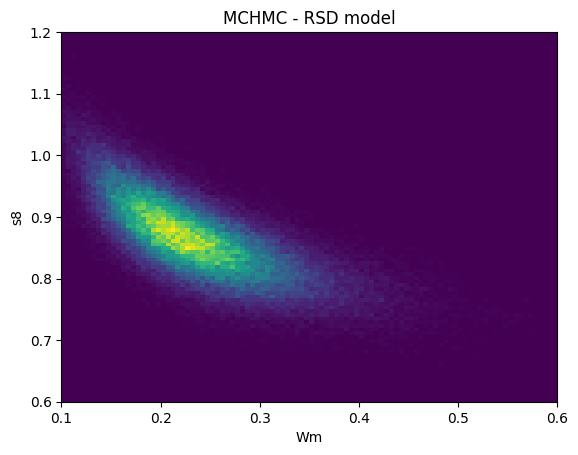

In [24]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [34]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=1.0), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

eps: 0.5 --> VarE: 1.1459880454568137


[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented using L = sqrt(target.d)
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:26
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.4648031932595167 --> VarE: 0.9212905080117936
eps: 0.48346011618025436 --> VarE: 0.7234572330585682
eps: 0.5551510312799794 --> VarE: 3.719676605775685
eps: 0.14250853637076571 --> VarE: 8.092864861374375
eps: 0.004108136303718149 --> VarE: 0.0062428236492344325
eps: 0.0067520628105378604 --> VarE: 0.03961621325967929
eps: 0.01091392997998507 --> VarE: 0.18350020204828546
eps: 0.01641654802638973 --> VarE: 0.7951901880553425
eps: 0.018186776390980625 --> VarE: 1.0457969917348138
Initial Virial loss: 3732.3695583434755
Initial sigma: [1.8967236408273025, 0.29770346066682674]
Virial loss: 58.85419052400678 --> Relative improvement: 0.03664784878371219
Sigma --> [1.8891872025594305, 0.29510891239876086]
Virial loss: 56.64575566660024 --> Relative improvement: 0.037523833693808406
Sigma --> [1.8841147463684949, 0.2930757081247666]


[ Info: VarE condition met during eps tuning at step: 10
[ Info: Found eps: 0.018186776390980625 ✅


Virial loss: 54.505778245173666 --> Relative improvement: 0.03777824827727305
Sigma --> [1.8794910234887374, 0.29120553130341176]
Virial loss: 52.44129095095442 --> Relative improvement: 0.03787648503857577
Sigma --> [1.874990372637352, 0.2894156410077349]
Virial loss: 50.45264909271613 --> Relative improvement: 0.037921298697588535
Sigma --> [1.8705228374736227, 0.28767738305527407]
Virial loss: 48.537917354081415 --> Relative improvement: 0.03795106447465302
Sigma --> [1.8660548175739788, 0.2859778821924581]
Virial loss: 46.694271637655945 --> Relative improvement: 0.03798361810574147
Sigma --> [1.8615706347782506, 0.28431029965221405]
Virial loss: 44.918508304468304 --> Relative improvement: 0.0380295755969261
Sigma --> [1.8570615772506773, 0.2826705465900607]
Virial loss: 43.20728021409812 --> Relative improvement: 0.038096280463524645
Sigma --> [1.852522200898658, 0.28105595280667206]
Virial loss: 41.557276401364696 --> Relative improvement: 0.03818809711135307
Sigma --> [1.847948

Sigma --> [1.5492123492865206, 0.2035610298139314]
Virial loss: 11.558730949551437 --> Relative improvement: 0.008914058493821653
Sigma --> [1.5457818974014756, 0.20282224938502016]
Virial loss: 11.625988476038156 --> Relative improvement: 0.0058187639093139065
Sigma --> [1.542378729985106, 0.20209159885518976]
Virial loss: 11.658869609947143 --> Relative improvement: 0.00282824415117533
Sigma --> [1.5390014119909565, 0.20136906495033416]
Virial loss: 11.659481785251504 --> Relative improvement: 5.25072605528365e-5
Sigma --> [1.53564848267259, 0.20065463182714338]


[ Info: Virial loss condition met during burn-in at step: 84
[ Info: Found sigma: [1.53564848267259, 0.20065463182714338] ✅


In [35]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

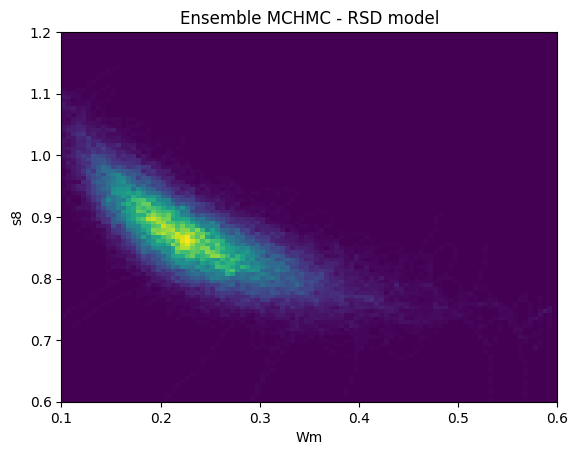

In [36]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [51]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.6850750430566057
samples: 100--> ESS: 0.06163782537062699


[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.4504347985333328, 0.06088870443750957] ✅
[ Info: Tuning eps ⏳
[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳


samples: 243--> ESS: 0.06416265192300356


[ Info: Found L: 3.117078144463292 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.51 seconds
Compute duration  = 0.51 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2391    0.0673     0.0007    0.0017   1070.5368    0.9999    ⋯
          σ8    0.8646    0.0620     0.0006    0.0014   1139.4333    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1303    0.1911    0.2314    0.2781    0.3928
          σ8    0.7557    0.8220    0.8607    0.9027    0.9998


In [52]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.55 seconds
Compute duration  = 0.55 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2350    0.0651     0.0007    0.0014   1108.5217    1.0000    ⋯
          σ8    0.8676    0.0610     0.0006    0.0012   1192.9598    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1310    0.1872    0.2276    0.2750    0.3828
          σ8    0.7560    0.8247    0.8648    0.9074    0.9960


## Ensemble AbstractMCMC

In [63]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented using L = sqrt(target.d)
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:25
[ Info: Found L: 1.4142135623730951 ✅
[ Info: Virial loss condition met during burn-in at step: 16
[ Info: Found sigma: [0.9423368793750067, 0.12029707296580826] ✅
[ Info: VarE condition met during eps tuning at step: 2
[ Info: Found eps: 0.25 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 2.89 seconds
Compute duration  = 2.89 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2364    0.0681     0.0002    0.0036   230.6565    1.0089     ⋯
          σ8    0.8671    0.0727     0.0002    0.0039   229.6471    1.0035     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1219    0.1821    0.2321    0.2700    0.3805
          σ8    0.7466    0.8157    0.8566    0.9170    1.0246


In [64]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 2.73 seconds
Compute duration  = 2.73 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2344    0.0695     0.0002    0.0037   222.3111    1.0069     ⋯
          σ8    0.8650    0.0601     0.0002    0.0032   229.1633    1.0012     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1462    0.1792    0.2214    0.2666    0.4265
          σ8    0.7594    0.8261    0.8612    0.8991    0.9836


## Parallelization

In [26]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Found sigma: [0.45043479852953877, 0.060888704437470666] ✅
[ Info: Tuning eps ⏳
[ Info: Found eps: 0.5 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 3.7055051070627916 ✅


eps: 0.5 --> VarE: 0.7436893047051621
samples: 100--> ESS: 0.08329897166540713
samples: 243--> ESS: 0.05397374830729411


chain 3:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   5%|██▏                                       |  ETA: 0:00:02
chain 4:   6%|██▎                                       |  ETA: 0:00:02
chain 1:   6%|██▎                                       |  ETA: 0:00:02

chain 3:  10%|████▎                                     |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  11%|████▋                                     |  ETA: 0:00:02
chain 1:  10%|████▍                                     |  ETA: 0:00:02
chain 2:  16%|██████▌                                   |  ETA: 0:00:02
chain 3:  16%|██████▌                                   |  ETA: 0:00:02
chain 4:  16%|██████▉                                   |  ETA: 0:00:02
chain 1:  16%|██████▊                                   |  ETA: 0:00:02

chain 2:  21%|████████▉                                 |  ETA: 0:00:02

chain 4:  22%|█████████▎                                |  ET

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [27]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 3:   6%|██▎                                       |  ETA: 0:00:02
chain 1:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   6%|██▎                                       |  ETA: 0:00:02
chain 4:   4%|█▉                                        |  ETA: 0:00:02
chain 3:  11%|████▋                                     |  ETA: 0:00:02



chain 2:  12%|████▉                                     |  ETA: 0:00:02
chain 1:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  10%|████▍                                     |  ETA: 0:00:02
chain 3:  16%|██████▉                                   |  ETA: 0:00:02

chain 1:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  16%|██████▊                                   |  ETA: 0:00:02
chain 2:  18%|███████▍                                  |  ETA: 0:00:02
chain 3:  22%|█████████                                 |  ETA: 0:00:02
chain 1:  22%|█████████  

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.55 seconds
Compute duration  = 9.55 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2335    0.0667     0.0007    0.0017   1455.0926    1.0003    ⋯
          σ8    0.8696    0.0640     0.0006    0.0014   2013.0454    1.0003    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.227798  0.84025   16.1292  31.0  1.0  …  4.0  0.0  0.0487068  0.0487068
 0.258169  0.834177  16.1515  19.0  1.0     4.0  0.0  0.0487068  0.0487068
 0.205094  0.868628  16.2104  23.0  1.0     4.0  0.0  0.0487068  0.0487068
 0.207729  0.853398  16.0517  11.0  1.0     3.0  0.0  0.0487068  0.0487068
 0.212726  0.910959  15.8526   3.0  1.0     2.0  0.0  0.0487068  0.0487068
 0.21327   0.924055  15.4529   3.0  1.0  …  2.0  0.0  0.0487068  0.0487068
 0.19658   0.877859  16.164   13.0  1.0     3.0  0.0  0.0487068  0.0487068
 0.19658   0.877859  16.164    1.0  1.0     1.0  0.0  0.0487068  0.0487068
 0.20096   0.905464  16.1046   9.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

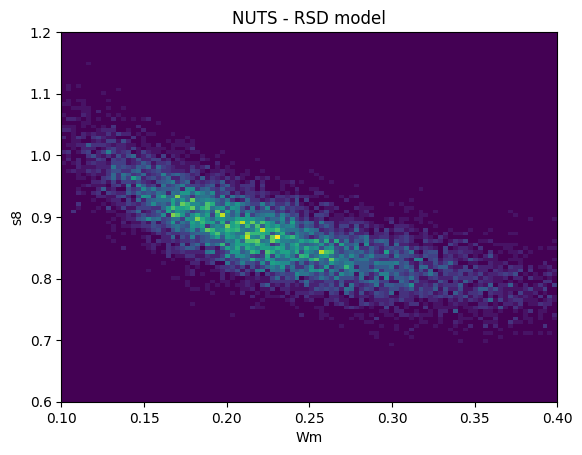

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");